Routines used to loop through image lists and print out information.

Also includes a routine to check for saturation, but need to have pixel mask (which can be made in Data_reduction_pipeline.ipynb) and need to analyze raw data.

In [24]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import filters

# Setting directory and imlist variables

In [25]:
directory_jupiter = '/Users/hannahgallamore/Desktop/Research/test3/PJ7_data_for_Hannah_test3/jupiter_raw/'
directory_stars = '/Users/hannahgallamore/Desktop/Research/test3/PJ7_data_for_Hannah_test3/stars_raw/'
directory_flats = '/Users/hannahgallamore/Desktop/Research/test3/PJ7_data_for_Hannah_test3/flats_raw/'
directory_pm = "/Users/hannahgallamore/Desktop/Research/test3/PJ7_data_for_Hannah_test3/"

jupiter = np.loadtxt(directory_jupiter+'imlist',dtype=str)
stars = np.loadtxt(directory_stars+'imlist',dtype=str)
flats = np.loadtxt(directory_flats+'imlist',dtype=str)

# Functions

In [26]:
# Print given keywords of interest for each file. Here, I'm printing the name of the file, whether that image is RF-on (1) or RF-off (0), the wavelength, the exposure time, and the UT date it was recorded
# This allows the user to find the beginning and end of a given datacube - this information can be used below to copy and paste a cube list into a new text file.

def print_info_jupiter(directory, data):

    for i in range(0,len(data)):
        im = fits.open(directory+data[i])
        print(data[i],im[0].header['rfon'],im[0].header['lambda'],im[0].header['exposure'],im[0].header['date'])
        im.close()
        
def print_info_stars(directory, data):

    #making star lists
    for i in range(0,len(data)):
        im = fits.open(directory+data[i])
        #if im[0].header['lambda'] > 950 and im[0].header['rfon'] == 1:
        print(data[i],im[0].header['rfon'],im[0].header['lambda'],im[0].header['exposure'],im[0].header['ut'],im[0].header['object'])
        im.close()
        
def print_info_flats(directory, data):

    for i in range(0,len(data)):
        im = fits.open(directory+data[i])
        print(data[i],im[0].header['lambda'],im[0].header['rfon'])        
        
# print out same image list, but without extra information. copy and paste collection of files of interest from this list.

def print_im_name(directory, data):

    for i in range(0,len(data)):
        im = fits.open(directory+data[i])
        print(data[i])
        im.close()
        
def repeat_wavelengths_test(directory, data):

    wl = []

    for i in range(0,len(data)):
        im = fits.open(directory+data[i])
        if im[0].header['rfon'] == 1:
            wl.append(im[0].header['lambda'])    
        im.close()

    repeat_wl = set([x for x in wl if wl.count(x) > 1])
    repeat_wl_list = list(repeat_wl)
    repeat_wl_list.sort()  

    if len(repeat_wl_list) > 0:
        print("There are", len(repeat_wl_list), "repeat wavelengths.")
        print("Repeat wavelengths:")
        print(repeat_wl_list)
        
    elif len(repeat_wl_list) == 0:
        print("There are no repeat wavelengths!")
        
    return wl, repeat_wl_list

def sat_check(directory,images,pixels):
    
    #images = '/home/users/dahlek/NAIC/cube_lists/feb_2017' #*location and list of images to check*
    #directory = '/zenith-data/dahlek/raw_data/2017-02-02/' #*data directory where fits files are*
    #pixels = '/zenith-data/dahlek/' #location and text file of pixel mask.*
    
    sat_value = 43836. #from linearity_tests.ipynb VALUE FOR OLD CAMERA, PRE-JAN 2018 DATA!
    #sat_value = 27073. #3-sigma VALUE FOR NEW CAMERA
    #sat_value = 30000. #test value
    #sat_value = 30400 #5 sigma value for new camera
    max_pixels_rfon = 6000 #from Paul's thesis
    max_pixels_rfoff = 10 #from Paul's thesis

    sat_images_rfon = []
    sat_images_rfoff = []
    number_of_rfoffs = []
    number_of_rfons = []
    unbinned = []

    imlist = np.loadtxt(images,dtype=str) #load the images to look at
    pixel_mask = np.loadtxt(pixels,dtype=int) #Array of positions of hot pixels (Don't count)

    for i in range(0,len(imlist)):

        sat_pix = []
        im = fits.open(directory+imlist[i])
        data = im[0].data
        header = im[0].header
        rf = header['rfon']
        if len(data) == 1024:
            unbinned.append(1)
            continue

        if rf == 1: #If RF is on, check if there are more than 6000 nonlinear pixels. 
            #Right here, put qualifiers for being within a certain position on the sky
            number_of_rfons.append(1)
            for x in range(0,len(im[0].data)):
                for j in range(0,len(im[0].data[x])):
                    #Qualifier to ignore bad pixels:
                    if pixel_mask[x][j] == 1:
                        continue
                    #If it's not a hot pixel, is it greater than the sat_value? If so, append a count
                    elif im[0].data[x][j] > sat_value:
                        sat_pix.append(1)       
            if len(sat_pix) >= max_pixels_rfon:
                #print 'There are more than 10 saturated pixels in',imlist[i]
                sat_images_rfon.append(imlist[i])


        else: #RF is off
            number_of_rfoffs.append(1)
            for x in range(0,len(im[0].data)):
                for j in range(0,len(im[0].data[x])):
                    #Qualifier to ignore bad pixels:
                    if pixel_mask[x][j] == 1:
                        continue
                    #If it's not a hot pixel, is it greater than the sat_value? If so, append a count
                    elif im[0].data[x][j] > sat_value:
                        sat_pix.append(1)
            if len(sat_pix) >= max_pixels_rfoff:
                sat_images_rfoff.append(imlist[i])

        #Save number of sat pixels to header
        header['SAT_VAL'] = (sat_value,'Saturation level (DN)')
        header['SAT_PIX'] = (len(sat_pix),'Number of pixels above saturation level')
        im.writeto(directory+imlist[i],overwrite=True)
        im.close()


    print('There were '+str(len(imlist))+' images total in '+directory)
    print('There were '+str(len(sat_images_rfoff))+' saturated RF-off images:')
    print(sat_images_rfoff)
    print('There were '+str(len(sat_images_rfon))+' saturated RF-on images:')
    print(sat_images_rfon)
    print('There were',str(len(unbinned)),'unbinned images that weren\'t analyzed.')

# Checking Jupiter

In [27]:
print_info_jupiter(directory_jupiter, jupiter)

NC0000178825.FIT 1 470.0 3.0 2017-03-27T10:24:56
NC0000178826.FIT 1 472.0 3.0 2017-03-27T10:25:00
NC0000178827.FIT 0 472.0 3.0 2017-03-27T10:25:04
NC0000178828.FIT 1 474.0 3.0 2017-03-27T10:25:08
NC0000178829.FIT 1 476.0 3.0 2017-03-27T10:25:13
NC0000178830.FIT 0 476.0 3.0 2017-03-27T10:25:17
NC0000178831.FIT 1 478.0 3.0 2017-03-27T10:25:21
NC0000178832.FIT 1 480.0 3.0 2017-03-27T10:25:25
NC0000178833.FIT 0 480.0 3.0 2017-03-27T10:25:29
NC0000178834.FIT 1 482.0 3.0 2017-03-27T10:25:34
NC0000178835.FIT 1 484.0 3.0 2017-03-27T10:25:38
NC0000178836.FIT 0 484.0 3.0 2017-03-27T10:25:42
NC0000178837.FIT 1 486.0 3.0 2017-03-27T10:25:46
NC0000178838.FIT 1 488.0 3.0 2017-03-27T10:25:51
NC0000178839.FIT 0 488.0 3.0 2017-03-27T10:25:55
NC0000178840.FIT 1 490.0 3.0 2017-03-27T10:25:59
NC0000178841.FIT 1 492.0 3.0 2017-03-27T10:26:03
NC0000178842.FIT 0 492.0 3.0 2017-03-27T10:26:07
NC0000178843.FIT 1 494.0 3.0 2017-03-27T10:26:12
NC0000178844.FIT 1 496.0 3.0 2017-03-27T10:26:16
NC0000178845.FIT 0 4

NC0000179055.FIT 1 754.0 0.6 2017-03-27T10:36:46
NC0000179056.FIT 1 756.0 0.6 2017-03-27T10:36:48
NC0000179057.FIT 0 756.0 0.6 2017-03-27T10:36:49
NC0000179058.FIT 1 758.0 0.6 2017-03-27T10:36:51
NC0000179059.FIT 1 760.0 0.6 2017-03-27T10:36:53
NC0000179060.FIT 0 760.0 0.6 2017-03-27T10:36:55
NC0000179061.FIT 1 762.0 0.6 2017-03-27T10:36:56
NC0000179062.FIT 1 764.0 0.6 2017-03-27T10:36:58
NC0000179063.FIT 0 764.0 0.6 2017-03-27T10:37:00
NC0000179064.FIT 1 766.0 0.6 2017-03-27T10:37:02
NC0000179065.FIT 1 768.0 0.6 2017-03-27T10:37:04
NC0000179066.FIT 0 768.0 0.6 2017-03-27T10:37:05
NC0000179067.FIT 1 770.0 0.6 2017-03-27T10:37:07
NC0000179068.FIT 1 772.0 0.6 2017-03-27T10:37:09
NC0000179069.FIT 0 772.0 0.6 2017-03-27T10:37:11
NC0000179070.FIT 1 774.0 0.6 2017-03-27T10:37:13
NC0000179071.FIT 1 776.0 0.6 2017-03-27T10:37:14
NC0000179072.FIT 0 776.0 0.6 2017-03-27T10:37:16
NC0000179073.FIT 1 778.0 0.6 2017-03-27T10:37:18
NC0000179074.FIT 1 780.0 0.6 2017-03-27T10:37:20
NC0000179075.FIT 0 7

In [28]:
print_im_name(directory_jupiter, jupiter)

NC0000178825.FIT
NC0000178826.FIT
NC0000178827.FIT
NC0000178828.FIT
NC0000178829.FIT
NC0000178830.FIT
NC0000178831.FIT
NC0000178832.FIT
NC0000178833.FIT
NC0000178834.FIT
NC0000178835.FIT
NC0000178836.FIT
NC0000178837.FIT
NC0000178838.FIT
NC0000178839.FIT
NC0000178840.FIT
NC0000178841.FIT
NC0000178842.FIT
NC0000178843.FIT
NC0000178844.FIT
NC0000178845.FIT
NC0000178846.FIT
NC0000178847.FIT
NC0000178848.FIT
NC0000178849.FIT
NC0000178850.FIT
NC0000178851.FIT
NC0000178852.FIT
NC0000178853.FIT
NC0000178854.FIT
NC0000178855.FIT
NC0000178856.FIT
NC0000178857.FIT
NC0000178858.FIT
NC0000178859.FIT
NC0000178860.FIT
NC0000178861.FIT
NC0000178862.FIT
NC0000178863.FIT
NC0000178864.FIT
NC0000178865.FIT
NC0000178866.FIT
NC0000178867.FIT
NC0000178868.FIT
NC0000178869.FIT
NC0000178870.FIT
NC0000178871.FIT
NC0000178872.FIT
NC0000178873.FIT
NC0000178874.FIT
NC0000178875.FIT
NC0000178876.FIT
NC0000178877.FIT
NC0000178878.FIT
NC0000178879.FIT
NC0000178880.FIT
NC0000178881.FIT
NC0000178882.FIT
NC0000178883.F

In [29]:
# Once list is saved, check list for repeat wavelengths
# If there aren't any repeat wavelenths, will return set()
# If there are repeat wavelengths, be sure to comment them out. Generally, repeat wavelengths arise after restarting a section of cube due to over-saturation, so it's generally safer to comment out the longer exposure times (especially if the following repeat wavelengths were imaged at a shorter exposure time)
        
wl_jupiter, repeat_wl_jupiter = repeat_wavelengths_test(directory_jupiter, jupiter)

There are no repeat wavelengths!


In [30]:
print(directory_pm + 'PJ7_march2017_pixelmask')

/Users/hannahgallamore/Desktop/Research/test3/PJ7_data_for_Hannah_test3/PJ7_march2017_pixelmask


In [31]:
sat_check(directory_jupiter, directory_jupiter + 'imlist', directory_pm + 'PJ7_march2017_pixelmask')

There were 365 images total in /Users/hannahgallamore/Desktop/Research/test3/PJ7_data_for_Hannah_test3/jupiter_raw/
There were 0 saturated RF-off images:
[]
There were 0 saturated RF-on images:
[]
There were 0 unbinned images that weren't analyzed.


# Checking Stars

In [32]:
print_info_stars(directory_stars, stars)

NC0000172290.FIT 1 470.0 4.5 02:49:59               q Vir
NC0000172291.FIT 1 472.0 4.5 02:50:05               q Vir
NC0000172292.FIT 0 472.0 4.5 02:50:11               q Vir
NC0000172293.FIT 1 474.0 4.5 02:50:17               q Vir
NC0000172294.FIT 1 476.0 4.5 02:50:22               q Vir
NC0000172295.FIT 0 476.0 4.5 02:50:28               q Vir
NC0000172296.FIT 1 478.0 4.5 02:50:34               q Vir
NC0000172297.FIT 1 480.0 4.5 02:50:39               q Vir
NC0000172298.FIT 0 480.0 4.5 02:50:45               q Vir
NC0000172299.FIT 1 482.0 4.5 02:50:51               q Vir
NC0000172300.FIT 1 484.0 4.5 02:50:56               q Vir
NC0000172301.FIT 0 484.0 4.5 02:51:02               q Vir
NC0000172302.FIT 1 486.0 4.5 02:51:08               q Vir
NC0000172303.FIT 1 488.0 4.5 02:51:14               q Vir
NC0000172304.FIT 0 488.0 4.5 02:51:19               q Vir
NC0000172305.FIT 1 490.0 4.5 02:51:25               q Vir
NC0000172306.FIT 1 492.0 4.5 02:51:31               q Vir
NC0000172307.F

NC0000172504.FIT 0 724.0 8.0 03:32:06               q Vir
NC0000172505.FIT 1 726.0 8.0 03:32:15               q Vir
NC0000172506.FIT 1 728.0 8.0 03:32:25               q Vir
NC0000172507.FIT 0 728.0 8.0 03:32:34               q Vir
NC0000172508.FIT 1 730.0 8.0 03:32:43               q Vir
NC0000172509.FIT 0 732.0 7.0 03:33:17               q Vir
NC0000172510.FIT 1 732.0 7.0 03:33:26               q Vir
NC0000172511.FIT 1 734.0 7.0 03:33:34               q Vir
NC0000172512.FIT 0 734.0 7.0 03:33:42               q Vir
NC0000172513.FIT 1 736.0 7.0 03:33:50               q Vir
NC0000172514.FIT 1 738.0 7.0 03:33:58               q Vir
NC0000172515.FIT 0 738.0 7.0 03:34:07               q Vir
NC0000172516.FIT 1 740.0 7.0 03:34:15               q Vir
NC0000172517.FIT 1 742.0 7.0 03:34:23               q Vir
NC0000172518.FIT 0 742.0 7.0 03:34:31               q Vir
NC0000172519.FIT 1 744.0 7.0 03:34:40               q Vir
NC0000172520.FIT 1 746.0 7.0 03:34:48               q Vir
NC0000172521.F

NC0000173494.FIT 1 518.0 5.0 04:47:15               q Vir
NC0000173495.FIT 1 520.0 5.0 04:47:22               q Vir
NC0000173496.FIT 0 520.0 5.0 04:47:28               q Vir
NC0000173497.FIT 1 522.0 5.0 04:47:34               q Vir
NC0000173498.FIT 1 524.0 5.0 04:47:40               q Vir
NC0000173499.FIT 0 524.0 5.0 04:47:46               q Vir
NC0000173500.FIT 1 526.0 5.0 04:47:53               q Vir
NC0000173501.FIT 1 528.0 5.0 04:47:59               q Vir
NC0000173502.FIT 0 528.0 5.0 04:48:05               q Vir
NC0000173503.FIT 1 530.0 5.0 04:48:11               q Vir
NC0000173504.FIT 1 532.0 5.0 04:48:18               q Vir
NC0000173505.FIT 0 532.0 5.0 04:48:24               q Vir
NC0000173506.FIT 1 534.0 5.0 04:48:30               q Vir
NC0000173507.FIT 1 536.0 5.0 04:48:36               q Vir
NC0000173508.FIT 0 536.0 5.0 04:48:42               q Vir
NC0000173509.FIT 1 538.0 5.0 04:48:49               q Vir
NC0000173510.FIT 1 540.0 5.0 04:48:55               q Vir
NC0000173511.F

NC0000173705.FIT 1 798.0 4.0 05:07:59               q Vir
NC0000173706.FIT 1 800.0 4.0 05:08:04               q Vir
NC0000173707.FIT 0 800.0 4.0 05:08:09               q Vir
NC0000173708.FIT 1 802.0 4.0 05:08:15               q Vir
NC0000173709.FIT 1 804.0 4.0 05:08:20               q Vir
NC0000173710.FIT 0 804.0 4.0 05:08:25               q Vir
NC0000173711.FIT 1 806.0 4.0 05:08:30               q Vir
NC0000173712.FIT 1 808.0 4.0 05:08:35               q Vir
NC0000173713.FIT 0 808.0 4.0 05:08:41               q Vir
NC0000173714.FIT 1 810.0 4.0 05:08:46               q Vir
NC0000173715.FIT 1 812.0 4.0 05:08:51               q Vir
NC0000173716.FIT 0 812.0 4.0 05:08:56               q Vir
NC0000173717.FIT 1 814.0 4.0 05:09:01               q Vir
NC0000173718.FIT 1 816.0 4.0 05:09:07               q Vir
NC0000173719.FIT 0 816.0 4.0 05:09:12               q Vir
NC0000173720.FIT 1 818.0 4.0 05:09:17               q Vir
NC0000173721.FIT 1 820.0 4.0 05:09:22               q Vir
NC0000173722.F

NC0000174697.FIT 1 588.0 5.0 06:17:11               q Vir
NC0000174698.FIT 0 588.0 5.0 06:17:18               q Vir
NC0000174699.FIT 1 590.0 5.0 06:17:24               q Vir
NC0000174700.FIT 1 592.0 5.0 06:17:30               q Vir
NC0000174701.FIT 0 592.0 5.0 06:17:36               q Vir
NC0000174702.FIT 1 594.0 5.0 06:17:42               q Vir
NC0000174703.FIT 1 596.0 5.0 06:17:49               q Vir
NC0000174704.FIT 0 596.0 5.0 06:17:55               q Vir
NC0000174705.FIT 1 598.0 5.0 06:18:01               q Vir
NC0000174706.FIT 1 600.0 5.0 06:18:07               q Vir
NC0000174707.FIT 0 600.0 5.0 06:18:13               q Vir
NC0000174708.FIT 1 602.0 5.0 06:18:20               q Vir
NC0000174709.FIT 1 604.0 5.0 06:18:26               q Vir
NC0000174710.FIT 0 604.0 5.0 06:18:32               q Vir
NC0000174711.FIT 1 606.0 5.0 06:18:38               q Vir
NC0000174712.FIT 1 608.0 5.0 06:18:45               q Vir
NC0000174713.FIT 0 608.0 5.0 06:18:51               q Vir
NC0000174714.F

NC0000174893.FIT 1 834.0 2.0 06:33:41               q Vir
NC0000174894.FIT 1 836.0 2.0 06:33:44               q Vir
NC0000174895.FIT 0 836.0 2.0 06:33:47               q Vir
NC0000174896.FIT 1 838.0 2.0 06:33:51               q Vir
NC0000174897.FIT 1 840.0 2.0 06:33:54               q Vir
NC0000174898.FIT 0 840.0 2.0 06:33:57               q Vir
NC0000174899.FIT 1 842.0 2.0 06:34:00               q Vir
NC0000174900.FIT 1 844.0 2.0 06:34:03               q Vir
NC0000174901.FIT 0 844.0 2.0 06:34:07               q Vir
NC0000174902.FIT 1 846.0 2.0 06:34:10               q Vir
NC0000174903.FIT 1 848.0 2.0 06:34:13               q Vir
NC0000174904.FIT 0 848.0 2.0 06:34:16               q Vir
NC0000174905.FIT 1 850.0 2.0 06:34:19               q Vir
NC0000174906.FIT 1 852.0 2.0 06:34:23               q Vir
NC0000174907.FIT 0 852.0 2.0 06:34:26               q Vir
NC0000174908.FIT 1 854.0 2.0 06:34:29               q Vir
NC0000174909.FIT 1 856.0 2.0 06:34:32               q Vir
NC0000174910.F

NC0000175910.FIT 1 620.0 5.0 07:36:44               q Vir
NC0000175911.FIT 1 622.0 5.0 07:36:50               q Vir
NC0000175912.FIT 0 622.0 5.0 07:36:56               q Vir
NC0000175913.FIT 1 624.0 5.0 07:37:03               q Vir
NC0000175914.FIT 1 626.0 5.0 07:37:09               q Vir
NC0000175915.FIT 0 626.0 5.0 07:37:15               q Vir
NC0000175916.FIT 1 628.0 5.0 07:37:21               q Vir
NC0000175917.FIT 1 630.0 5.0 07:37:28               q Vir
NC0000175918.FIT 0 630.0 5.0 07:37:34               q Vir
NC0000175919.FIT 1 632.0 5.0 07:37:40               q Vir
NC0000175920.FIT 1 634.0 5.0 07:37:46               q Vir
NC0000175921.FIT 0 634.0 5.0 07:37:52               q Vir
NC0000175922.FIT 1 636.0 5.0 07:37:59               q Vir
NC0000175923.FIT 1 638.0 5.0 07:38:05               q Vir
NC0000175924.FIT 0 638.0 5.0 07:38:11               q Vir
NC0000175925.FIT 1 640.0 5.0 07:38:17               q Vir
NC0000175926.FIT 1 642.0 5.0 07:38:24               q Vir
NC0000175927.F

NC0000176128.FIT 1 896.0 3.0 07:55:52               q Vir
NC0000176129.FIT 1 898.0 3.0 07:55:56               q Vir
NC0000176130.FIT 0 898.0 3.0 07:56:00               q Vir
NC0000176131.FIT 1 900.0 3.0 07:56:04               q Vir
NC0000176132.FIT 1 902.0 3.0 07:56:09               q Vir
NC0000176133.FIT 0 902.0 3.0 07:56:13               q Vir
NC0000176134.FIT 1 904.0 3.0 07:56:17               q Vir
NC0000176135.FIT 1 906.0 3.0 07:56:21               q Vir
NC0000176136.FIT 0 906.0 3.0 07:56:25               q Vir
NC0000176137.FIT 1 908.0 3.0 07:56:30               q Vir
NC0000176138.FIT 1 910.0 3.0 07:56:34               q Vir
NC0000176139.FIT 0 910.0 3.0 07:56:38               q Vir
NC0000176140.FIT 1 912.0 3.0 07:56:42               q Vir
NC0000176141.FIT 1 914.0 3.0 07:56:46               q Vir
NC0000176142.FIT 0 914.0 3.0 07:56:51               q Vir
NC0000176143.FIT 1 916.0 3.0 07:56:55               q Vir
NC0000176144.FIT 1 918.0 3.0 07:56:59               q Vir
NC0000176145.F

NC0000177103.FIT 0 694.0 2.0 08:54:34               q Vir
NC0000177104.FIT 1 696.0 2.0 08:54:38               q Vir
NC0000177105.FIT 1 698.0 2.0 08:54:41               q Vir
NC0000177106.FIT 0 698.0 2.0 08:54:44               q Vir
NC0000177107.FIT 1 700.0 2.0 08:54:47               q Vir
NC0000177108.FIT 1 702.0 2.0 08:54:51               q Vir
NC0000177109.FIT 0 702.0 2.0 08:54:54               q Vir
NC0000177110.FIT 1 704.0 2.0 08:54:57               q Vir
NC0000177111.FIT 1 706.0 2.0 08:55:00               q Vir
NC0000177112.FIT 0 706.0 2.0 08:55:03               q Vir
NC0000177113.FIT 1 708.0 2.0 08:55:07               q Vir
NC0000177114.FIT 1 710.0 2.0 08:55:10               q Vir
NC0000177115.FIT 0 710.0 2.0 08:55:13               q Vir
NC0000177116.FIT 1 712.0 2.0 08:55:16               q Vir
NC0000177117.FIT 1 714.0 2.0 08:55:20               q Vir
NC0000177118.FIT 0 714.0 2.0 08:55:23               q Vir
NC0000177119.FIT 1 716.0 2.0 08:55:26               q Vir
NC0000177120.F

NC0000178061.FIT 0 500.0 3.5 09:43:00               q Vir
NC0000178062.FIT 1 502.0 3.5 09:43:04               q Vir
NC0000178063.FIT 1 504.0 3.5 09:43:09               q Vir
NC0000178064.FIT 0 504.0 3.5 09:43:14               q Vir
NC0000178065.FIT 1 506.0 3.5 09:43:18               q Vir
NC0000178066.FIT 1 508.0 3.5 09:43:23               q Vir
NC0000178067.FIT 0 508.0 3.5 09:43:28               q Vir
NC0000178068.FIT 1 510.0 3.5 09:43:32               q Vir
NC0000178069.FIT 1 512.0 3.5 09:43:37               q Vir
NC0000178070.FIT 0 512.0 3.5 09:43:42               q Vir
NC0000178071.FIT 1 514.0 3.5 09:43:47               q Vir
NC0000178072.FIT 1 516.0 3.5 09:43:51               q Vir
NC0000178073.FIT 0 516.0 3.5 09:43:56               q Vir
NC0000178074.FIT 1 518.0 3.5 09:44:01               q Vir
NC0000178075.FIT 1 520.0 3.5 09:44:06               q Vir
NC0000178076.FIT 0 520.0 3.5 09:44:10               q Vir
NC0000178077.FIT 1 522.0 3.5 09:44:15               q Vir
NC0000178078.F

NC0000178262.FIT 1 766.0 1.5 09:54:00               q Vir
NC0000178263.FIT 1 768.0 1.5 09:54:03               q Vir
NC0000178264.FIT 0 768.0 1.5 09:54:05               q Vir
NC0000178265.FIT 1 770.0 1.5 09:54:08               q Vir
NC0000178266.FIT 1 772.0 1.5 09:54:11               q Vir
NC0000178267.FIT 0 772.0 1.5 09:54:13               q Vir
NC0000178268.FIT 1 774.0 1.5 09:54:16               q Vir
NC0000178269.FIT 1 776.0 1.5 09:54:19               q Vir
NC0000178270.FIT 0 776.0 1.5 09:54:22               q Vir
NC0000178271.FIT 1 778.0 1.5 09:54:24               q Vir
NC0000178272.FIT 1 780.0 1.5 09:54:27               q Vir
NC0000178273.FIT 0 780.0 1.5 09:54:30               q Vir
NC0000178274.FIT 1 782.0 1.5 09:54:32               q Vir
NC0000178275.FIT 1 784.0 1.5 09:54:35               q Vir
NC0000178276.FIT 0 784.0 1.5 09:54:38               q Vir
NC0000178277.FIT 1 786.0 1.5 09:54:41               q Vir
NC0000178278.FIT 1 788.0 1.5 09:54:43               q Vir
NC0000178279.F

NC0000179261.FIT 0 542.0 5.0 10:52:49              85 Vir
NC0000179262.FIT 1 544.0 5.0 10:52:56              85 Vir
NC0000179263.FIT 1 546.0 5.0 10:53:02              85 Vir
NC0000179264.FIT 0 546.0 5.0 10:53:08              85 Vir
NC0000179265.FIT 1 548.0 5.0 10:53:14              85 Vir
NC0000179266.FIT 1 550.0 5.0 10:53:20              85 Vir
NC0000179267.FIT 0 550.0 5.0 10:53:27              85 Vir
NC0000179268.FIT 1 552.0 5.0 10:53:33              85 Vir
NC0000179269.FIT 1 554.0 5.0 10:53:39              85 Vir
NC0000179270.FIT 0 554.0 5.0 10:53:45              85 Vir
NC0000179271.FIT 1 556.0 5.0 10:53:51              85 Vir
NC0000179272.FIT 1 558.0 5.0 10:53:58              85 Vir
NC0000179273.FIT 0 558.0 5.0 10:54:04              85 Vir
NC0000179274.FIT 1 560.0 5.0 10:54:10              85 Vir
NC0000179275.FIT 1 562.0 5.0 10:54:16              85 Vir
NC0000179276.FIT 0 562.0 3.0 10:54:32              85 Vir
NC0000179277.FIT 1 560.0 3.0 10:54:36              85 Vir
NC0000179278.F

NC0000179464.FIT 1 808.0 2.0 11:05:54              85 Vir
NC0000179465.FIT 0 808.0 2.0 11:05:57              85 Vir
NC0000179466.FIT 1 810.0 2.0 11:06:00              85 Vir
NC0000179467.FIT 1 812.0 2.0 11:06:04              85 Vir
NC0000179468.FIT 0 812.0 2.0 11:06:07              85 Vir
NC0000179469.FIT 1 814.0 2.0 11:06:10              85 Vir
NC0000179470.FIT 1 816.0 2.0 11:06:13              85 Vir
NC0000179471.FIT 0 816.0 2.0 11:06:16              85 Vir
NC0000179472.FIT 1 818.0 2.0 11:06:20              85 Vir
NC0000179473.FIT 1 820.0 2.0 11:06:23              85 Vir
NC0000179474.FIT 0 820.0 2.0 11:06:26              85 Vir
NC0000179475.FIT 1 822.0 2.0 11:06:29              85 Vir
NC0000179476.FIT 1 824.0 2.0 11:06:32              85 Vir
NC0000179477.FIT 0 824.0 2.0 11:06:36              85 Vir
NC0000179478.FIT 1 826.0 2.0 11:06:39              85 Vir
NC0000179479.FIT 1 828.0 2.0 11:06:42              85 Vir
NC0000179480.FIT 0 828.0 2.0 11:06:45              85 Vir
NC0000179481.F

NC0000180471.FIT 1 600.0 5.0 12:08:43              85 Vir
NC0000180472.FIT 0 600.0 5.0 12:08:49              85 Vir
NC0000180473.FIT 1 602.0 5.0 12:08:55              85 Vir
NC0000180474.FIT 1 604.0 5.0 12:09:01              85 Vir
NC0000180475.FIT 0 604.0 5.0 12:09:07              85 Vir
NC0000180476.FIT 1 606.0 5.0 12:09:14              85 Vir
NC0000180477.FIT 0 608.0 4.0 12:09:39              85 Vir
NC0000180478.FIT 1 608.0 4.0 12:09:45              85 Vir
NC0000180479.FIT 1 610.0 4.0 12:09:50              85 Vir
NC0000180480.FIT 0 610.0 4.0 12:09:55              85 Vir
NC0000180481.FIT 1 612.0 4.0 12:10:00              85 Vir
NC0000180482.FIT 1 614.0 4.0 12:10:06              85 Vir
NC0000180483.FIT 0 614.0 4.0 12:10:11              85 Vir
NC0000180484.FIT 1 616.0 4.0 12:10:16              85 Vir
NC0000180485.FIT 1 618.0 4.0 12:10:21              85 Vir
NC0000180486.FIT 0 618.0 4.0 12:10:26              85 Vir
NC0000180487.FIT 1 620.0 4.0 12:10:32              85 Vir
NC0000180488.F

NC0000180680.FIT 1 876.0 3.0 12:25:37              85 Vir
NC0000180681.FIT 1 878.0 3.0 12:25:42              85 Vir
NC0000180682.FIT 0 878.0 3.0 12:25:46              85 Vir
NC0000180683.FIT 1 880.0 3.0 12:25:50              85 Vir
NC0000180684.FIT 1 882.0 3.0 12:25:54              85 Vir
NC0000180685.FIT 0 882.0 3.0 12:25:58              85 Vir
NC0000180686.FIT 1 884.0 3.0 12:26:03              85 Vir
NC0000180687.FIT 1 886.0 3.0 12:26:07              85 Vir
NC0000180688.FIT 0 886.0 3.0 12:26:11              85 Vir
NC0000180689.FIT 1 888.0 3.0 12:26:15              85 Vir
NC0000180690.FIT 1 890.0 3.0 12:26:20              85 Vir
NC0000180691.FIT 0 890.0 3.0 12:26:24              85 Vir
NC0000180692.FIT 1 892.0 3.0 12:26:28              85 Vir
NC0000180693.FIT 1 894.0 3.0 12:26:32              85 Vir
NC0000180694.FIT 0 894.0 3.0 12:26:36              85 Vir
NC0000180695.FIT 1 896.0 3.0 12:26:41              85 Vir
NC0000180696.FIT 1 898.0 3.0 12:26:45              85 Vir
NC0000180697.F

In [33]:
print_im_name(directory_stars, stars)

NC0000172290.FIT
NC0000172291.FIT
NC0000172292.FIT
NC0000172293.FIT
NC0000172294.FIT
NC0000172295.FIT
NC0000172296.FIT
NC0000172297.FIT
NC0000172298.FIT
NC0000172299.FIT
NC0000172300.FIT
NC0000172301.FIT
NC0000172302.FIT
NC0000172303.FIT
NC0000172304.FIT
NC0000172305.FIT
NC0000172306.FIT
NC0000172307.FIT
NC0000172308.FIT
NC0000172309.FIT
NC0000172310.FIT
NC0000172311.FIT
NC0000172312.FIT
NC0000172313.FIT
NC0000172314.FIT
NC0000172315.FIT
NC0000172316.FIT
NC0000172317.FIT
NC0000172318.FIT
NC0000172319.FIT
NC0000172320.FIT
NC0000172321.FIT
NC0000172322.FIT
NC0000172323.FIT
NC0000172324.FIT
NC0000172325.FIT
NC0000172326.FIT
NC0000172327.FIT
NC0000172328.FIT
NC0000172329.FIT
NC0000172330.FIT
NC0000172331.FIT
NC0000172332.FIT
NC0000172333.FIT
NC0000172334.FIT
NC0000172335.FIT
NC0000172336.FIT
NC0000172337.FIT
NC0000172338.FIT
NC0000172339.FIT
NC0000172340.FIT
NC0000172341.FIT
NC0000172342.FIT
NC0000172343.FIT
NC0000172344.FIT
NC0000172345.FIT
NC0000172346.FIT
NC0000172347.FIT
NC0000172348.F

NC0000173615.FIT
NC0000173616.FIT
NC0000173617.FIT
NC0000173618.FIT
NC0000173619.FIT
NC0000173620.FIT
NC0000173621.FIT
NC0000173622.FIT
NC0000173623.FIT
NC0000173624.FIT
NC0000173625.FIT
NC0000173626.FIT
NC0000173627.FIT
NC0000173628.FIT
NC0000173629.FIT
NC0000173630.FIT
NC0000173631.FIT
NC0000173632.FIT
NC0000173633.FIT
NC0000173634.FIT
NC0000173635.FIT
NC0000173636.FIT
NC0000173637.FIT
NC0000173638.FIT
NC0000173639.FIT
NC0000173640.FIT
NC0000173641.FIT
NC0000173642.FIT
NC0000173643.FIT
NC0000173644.FIT
NC0000173645.FIT
NC0000173646.FIT
NC0000173647.FIT
NC0000173648.FIT
NC0000173649.FIT
NC0000173650.FIT
NC0000173651.FIT
NC0000173652.FIT
NC0000173653.FIT
NC0000173654.FIT
NC0000173655.FIT
NC0000173656.FIT
NC0000173657.FIT
NC0000173658.FIT
NC0000173659.FIT
NC0000173660.FIT
NC0000173661.FIT
NC0000173662.FIT
NC0000173663.FIT
NC0000173664.FIT
NC0000173665.FIT
NC0000173666.FIT
NC0000173667.FIT
NC0000173668.FIT
NC0000173669.FIT
NC0000173670.FIT
NC0000173671.FIT
NC0000173672.FIT
NC0000173673.F

NC0000174942.FIT
NC0000174943.FIT
NC0000174944.FIT
NC0000174945.FIT
NC0000174946.FIT
NC0000174947.FIT
NC0000174948.FIT
NC0000174949.FIT
NC0000174950.FIT
NC0000174951.FIT
NC0000174952.FIT
NC0000174953.FIT
NC0000174954.FIT
NC0000174955.FIT
NC0000174956.FIT
NC0000174957.FIT
NC0000174958.FIT
NC0000174959.FIT
NC0000174960.FIT
NC0000174961.FIT
NC0000174962.FIT
NC0000174963.FIT
NC0000174964.FIT
NC0000174965.FIT
NC0000174966.FIT
NC0000174967.FIT
NC0000174968.FIT
NC0000174969.FIT
NC0000174970.FIT
NC0000174971.FIT
NC0000174972.FIT
NC0000174973.FIT
NC0000174974.FIT
NC0000174975.FIT
NC0000174976.FIT
NC0000174977.FIT
NC0000174978.FIT
NC0000174979.FIT
NC0000174980.FIT
NC0000174981.FIT
NC0000174982.FIT
NC0000174983.FIT
NC0000175793.FIT
NC0000175794.FIT
NC0000175795.FIT
NC0000175796.FIT
NC0000175797.FIT
NC0000175798.FIT
NC0000175799.FIT
NC0000175800.FIT
NC0000175801.FIT
NC0000175802.FIT
NC0000175803.FIT
NC0000175804.FIT
NC0000175805.FIT
NC0000175806.FIT
NC0000175807.FIT
NC0000175808.FIT
NC0000175809.F

NC0000177063.FIT
NC0000177064.FIT
NC0000177065.FIT
NC0000177066.FIT
NC0000177067.FIT
NC0000177068.FIT
NC0000177069.FIT
NC0000177070.FIT
NC0000177071.FIT
NC0000177072.FIT
NC0000177073.FIT
NC0000177074.FIT
NC0000177075.FIT
NC0000177076.FIT
NC0000177077.FIT
NC0000177078.FIT
NC0000177079.FIT
NC0000177080.FIT
NC0000177081.FIT
NC0000177082.FIT
NC0000177083.FIT
NC0000177084.FIT
NC0000177085.FIT
NC0000177086.FIT
NC0000177087.FIT
NC0000177088.FIT
NC0000177089.FIT
NC0000177090.FIT
NC0000177091.FIT
NC0000177092.FIT
NC0000177093.FIT
NC0000177094.FIT
NC0000177095.FIT
NC0000177096.FIT
NC0000177097.FIT
NC0000177098.FIT
NC0000177099.FIT
NC0000177100.FIT
NC0000177101.FIT
NC0000177102.FIT
NC0000177103.FIT
NC0000177104.FIT
NC0000177105.FIT
NC0000177106.FIT
NC0000177107.FIT
NC0000177108.FIT
NC0000177109.FIT
NC0000177110.FIT
NC0000177111.FIT
NC0000177112.FIT
NC0000177113.FIT
NC0000177114.FIT
NC0000177115.FIT
NC0000177116.FIT
NC0000177117.FIT
NC0000177118.FIT
NC0000177119.FIT
NC0000177120.FIT
NC0000177121.F

NC0000178330.FIT
NC0000178331.FIT
NC0000178332.FIT
NC0000178333.FIT
NC0000178334.FIT
NC0000178335.FIT
NC0000178336.FIT
NC0000178337.FIT
NC0000178338.FIT
NC0000178339.FIT
NC0000178340.FIT
NC0000178341.FIT
NC0000178342.FIT
NC0000178343.FIT
NC0000178344.FIT
NC0000178345.FIT
NC0000178346.FIT
NC0000178347.FIT
NC0000178348.FIT
NC0000178349.FIT
NC0000178350.FIT
NC0000178351.FIT
NC0000178352.FIT
NC0000178353.FIT
NC0000178354.FIT
NC0000178355.FIT
NC0000178356.FIT
NC0000178357.FIT
NC0000178358.FIT
NC0000178359.FIT
NC0000178360.FIT
NC0000178361.FIT
NC0000178362.FIT
NC0000178363.FIT
NC0000178364.FIT
NC0000178365.FIT
NC0000178366.FIT
NC0000178367.FIT
NC0000178368.FIT
NC0000178369.FIT
NC0000178370.FIT
NC0000178371.FIT
NC0000178372.FIT
NC0000178373.FIT
NC0000178374.FIT
NC0000178375.FIT
NC0000178376.FIT
NC0000178377.FIT
NC0000178378.FIT
NC0000178379.FIT
NC0000178380.FIT
NC0000178381.FIT
NC0000178382.FIT
NC0000178383.FIT
NC0000178384.FIT
NC0000178385.FIT
NC0000178386.FIT
NC0000178387.FIT
NC0000178388.F

NC0000180481.FIT
NC0000180482.FIT
NC0000180483.FIT
NC0000180484.FIT
NC0000180485.FIT
NC0000180486.FIT
NC0000180487.FIT
NC0000180488.FIT
NC0000180489.FIT
NC0000180490.FIT
NC0000180491.FIT
NC0000180492.FIT
NC0000180493.FIT
NC0000180494.FIT
NC0000180495.FIT
NC0000180496.FIT
NC0000180497.FIT
NC0000180498.FIT
NC0000180499.FIT
NC0000180500.FIT
NC0000180501.FIT
NC0000180502.FIT
NC0000180503.FIT
NC0000180504.FIT
NC0000180505.FIT
NC0000180506.FIT
NC0000180507.FIT
NC0000180508.FIT
NC0000180509.FIT
NC0000180510.FIT
NC0000180511.FIT
NC0000180512.FIT
NC0000180513.FIT
NC0000180514.FIT
NC0000180515.FIT
NC0000180516.FIT
NC0000180517.FIT
NC0000180518.FIT
NC0000180519.FIT
NC0000180520.FIT
NC0000180521.FIT
NC0000180522.FIT
NC0000180523.FIT
NC0000180524.FIT
NC0000180525.FIT
NC0000180526.FIT
NC0000180527.FIT
NC0000180528.FIT
NC0000180529.FIT
NC0000180530.FIT
NC0000180531.FIT
NC0000180532.FIT
NC0000180533.FIT
NC0000180534.FIT
NC0000180535.FIT
NC0000180536.FIT
NC0000180537.FIT
NC0000180538.FIT
NC0000180539.F

In [34]:
wl_stars, repeat_wl_stars = repeat_wavelengths_test(directory_stars, stars)

There are 241 repeat wavelengths.
Repeat wavelengths:
[470.0, 472.0, 474.0, 476.0, 478.0, 480.0, 482.0, 484.0, 486.0, 488.0, 490.0, 492.0, 494.0, 496.0, 498.0, 500.0, 502.0, 504.0, 506.0, 508.0, 510.0, 512.0, 514.0, 516.0, 518.0, 520.0, 522.0, 524.0, 526.0, 528.0, 530.0, 532.0, 534.0, 536.0, 538.0, 540.0, 542.0, 544.0, 546.0, 548.0, 550.0, 552.0, 554.0, 556.0, 558.0, 560.0, 562.0, 564.0, 566.0, 568.0, 570.0, 572.0, 574.0, 576.0, 578.0, 580.0, 582.0, 584.0, 586.0, 588.0, 590.0, 592.0, 594.0, 596.0, 598.0, 600.0, 602.0, 604.0, 606.0, 608.0, 610.0, 612.0, 614.0, 616.0, 618.0, 620.0, 622.0, 624.0, 626.0, 628.0, 630.0, 632.0, 634.0, 636.0, 638.0, 640.0, 642.0, 644.0, 646.0, 648.0, 650.0, 652.0, 654.0, 656.0, 658.0, 660.0, 662.0, 664.0, 666.0, 668.0, 670.0, 672.0, 674.0, 676.0, 678.0, 680.0, 682.0, 684.0, 686.0, 688.0, 690.0, 692.0, 694.0, 696.0, 698.0, 700.0, 702.0, 704.0, 706.0, 708.0, 710.0, 712.0, 714.0, 716.0, 718.0, 720.0, 722.0, 724.0, 726.0, 728.0, 730.0, 732.0, 734.0, 736.0, 738.0, 

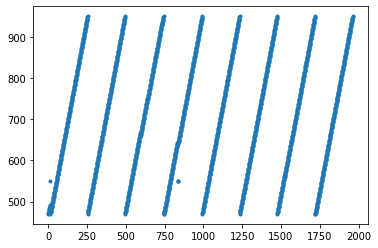

In [35]:
# Sometimes it's useful to visualize the wavelengths over the course of a cube
plt.plot(wl_stars ,'.')
plt.show()

# Checking Flats

In [36]:
print_info_flats(directory_flats, flats)

NC0000170514.FIT 470.0 1
NC0000170515.FIT 474.0 1
NC0000170516.FIT 478.0 1
NC0000170517.FIT 482.0 1
NC0000170518.FIT 482.0 0
NC0000170519.FIT 486.0 1
NC0000170520.FIT 490.0 1
NC0000170521.FIT 494.0 1
NC0000170522.FIT 498.0 1
NC0000170523.FIT 498.0 0
NC0000170524.FIT 502.0 1
NC0000170525.FIT 506.0 1
NC0000170526.FIT 510.0 1
NC0000170527.FIT 514.0 1
NC0000170528.FIT 514.0 0
NC0000170529.FIT 518.0 1
NC0000170530.FIT 522.0 1
NC0000170531.FIT 526.0 1
NC0000170532.FIT 530.0 1
NC0000170533.FIT 530.0 0
NC0000170534.FIT 534.0 1
NC0000170535.FIT 538.0 0
NC0000170536.FIT 538.0 1
NC0000170537.FIT 542.0 1
NC0000170538.FIT 546.0 1
NC0000170539.FIT 550.0 1
NC0000170540.FIT 550.0 0
NC0000170541.FIT 554.0 1
NC0000170542.FIT 558.0 1
NC0000170543.FIT 562.0 1
NC0000170544.FIT 566.0 0
NC0000170545.FIT 566.0 1
NC0000170546.FIT 570.0 1
NC0000170547.FIT 574.0 1
NC0000170548.FIT 578.0 1
NC0000170549.FIT 578.0 0
NC0000170550.FIT 582.0 1
NC0000170551.FIT 586.0 1
NC0000170552.FIT 590.0 1
NC0000170553.FIT 594.0 1


In [37]:
print_im_name(directory_flats, flats)

NC0000170514.FIT
NC0000170515.FIT
NC0000170516.FIT
NC0000170517.FIT
NC0000170518.FIT
NC0000170519.FIT
NC0000170520.FIT
NC0000170521.FIT
NC0000170522.FIT
NC0000170523.FIT
NC0000170524.FIT
NC0000170525.FIT
NC0000170526.FIT
NC0000170527.FIT
NC0000170528.FIT
NC0000170529.FIT
NC0000170530.FIT
NC0000170531.FIT
NC0000170532.FIT
NC0000170533.FIT
NC0000170534.FIT
NC0000170535.FIT
NC0000170536.FIT
NC0000170537.FIT
NC0000170538.FIT
NC0000170539.FIT
NC0000170540.FIT
NC0000170541.FIT
NC0000170542.FIT
NC0000170543.FIT
NC0000170544.FIT
NC0000170545.FIT
NC0000170546.FIT
NC0000170547.FIT
NC0000170548.FIT
NC0000170549.FIT
NC0000170550.FIT
NC0000170551.FIT
NC0000170552.FIT
NC0000170553.FIT
NC0000170554.FIT
NC0000170555.FIT
NC0000170556.FIT
NC0000170557.FIT
NC0000170558.FIT
NC0000170559.FIT
NC0000170560.FIT
NC0000170561.FIT
NC0000170562.FIT
NC0000170563.FIT
NC0000170564.FIT
NC0000170565.FIT
NC0000170566.FIT
NC0000170567.FIT
NC0000170568.FIT
NC0000170569.FIT
NC0000170570.FIT
NC0000170571.FIT
NC0000170572.F

In [38]:
wl_flats, repeat_wl_flats = repeat_wavelengths_test(directory_flats, flats)

There are no repeat wavelengths!


In [39]:
sat_check(directory_flats, directory_flats + 'imlist', directory_pm + 'PJ7_march2017_pixelmask')

There were 309 images total in /Users/hannahgallamore/Desktop/Research/test3/PJ7_data_for_Hannah_test3/flats_raw/
There were 0 saturated RF-off images:
[]
There were 0 saturated RF-on images:
[]
There were 0 unbinned images that weren't analyzed.


# Some Visualization Tests

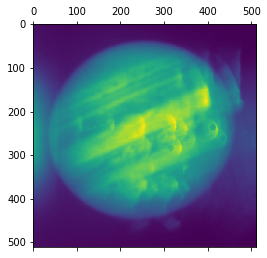

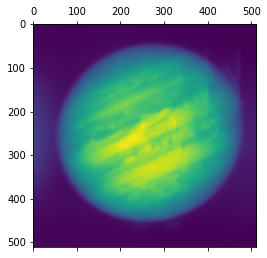

In [40]:
# plot some raw data if you feel like it
plt.matshow(fits.open(directory_jupiter+jupiter[15])[0].data)
plt.matshow(fits.open(directory_jupiter+jupiter[150])[0].data)
plt.show()

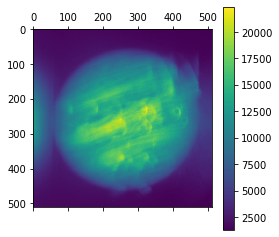

In [41]:
im = fits.open('/Users/hannahgallamore/Desktop/Research/test3/PJ7_data_for_Hannah_test3/jupiter_raw/NC0000179196.FIT')
plt.matshow(im[0].data)
plt.colorbar()
plt.show()

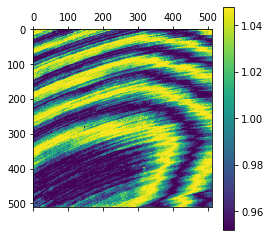

In [42]:
imfringe = fits.open('/Users/hannahgallamore/Desktop/Research/test3/PJ7_data_for_Hannah_test3/March_2017_data_new_Synthetic_fringe_files/Jupiter/NC0000179196.FIT')
plt.matshow(imfringe[0].data)
plt.colorbar()
plt.show()

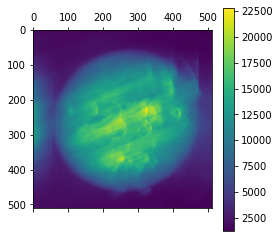

In [43]:
plt.matshow(im[0].data/imfringe[0].data)
plt.colorbar()
plt.show()